<a href="https://colab.research.google.com/github/shivanipal21/Bharat-Gas-Booking/blob/master/Breast_Cancer_Detection_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ✅ Step 1: Import libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [ ]:
# Upload kaggle.json
from google.colab import files
files.upload()   # <-- Select your kaggle.json file

#  Move kaggle.json to ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

#  Unzip dataset (overwrite automatically)
!unzip -o -q breast-histopathology-images.zip -d /content/dataset

# Verify some files
import os
for root, dirs, files in os.walk("/content/dataset"):
    print(f"📂 Folder: {root}, Files: {len(files)}")
    break


Saving kaggle (1).json to kaggle (1) (1).json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images
License(s): CC0-1.0
breast-histopathology-images.zip: Skipping, found more recently modified local copy (use --force to force download)
📂 Folder: /content/dataset, Files: 0


In [ ]:
# Unzip (overwrite, quiet)
!unzip -o -q breast-histopathology-images.zip -d /content/dataset

# Walk deeper into folders
import os

for root, dirs, files in os.walk("/content/dataset"):
    print(f" Folder: {root}, Files: {len(files)}")
    # stop after first few levels
    if len(files) > 0:
        break


 Folder: /content/dataset, Files: 0
 Folder: /content/dataset/16553, Files: 0
 Folder: /content/dataset/16553/1, Files: 353


In [ ]:
benign_count = 0
malignant_count = 0

for root, dirs, files in os.walk("/content/dataset/IDC_regular_ps50_idx5"):
    for f in files:
        if "class0" in f:   # benign
            benign_count += 1
        elif "class1" in f: # malignant
            malignant_count += 1

print("Benign samples:", benign_count)
print("Malignant samples:", malignant_count)


Benign samples: 198738
Malignant samples: 78786


In [ ]:
import os
import pandas as pd

image_paths = []
labels = []

# Walk through dataset and collect files
for root, dirs, files in os.walk("/content/dataset/IDC_regular_ps50_idx5"):
    for file in files:
        if file.endswith(".png"):
            path = os.path.join(root, file)
            label = 1 if "class1" in file else 0   # malignant=1, benign=0
            image_paths.append(path)
            labels.append(label)

df = pd.DataFrame({"path": image_paths, "label": labels})
print(df.head())
print("Total images:", len(df))
print("Benign:", (df["label"]==0).sum(), " Malignant:", (df["label"]==1).sum())


                                                path  label
0  /content/dataset/IDC_regular_ps50_idx5/16553/1...      1
1  /content/dataset/IDC_regular_ps50_idx5/16553/1...      1
2  /content/dataset/IDC_regular_ps50_idx5/16553/1...      1
3  /content/dataset/IDC_regular_ps50_idx5/16553/1...      1
4  /content/dataset/IDC_regular_ps50_idx5/16553/1...      1
Total images: 277524
Benign: 198738  Malignant: 78786


In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))


Train size: 222019
Validation size: 55505


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

# Convert labels to strings for binary classification
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)


train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="path",
    y_col="label",
    target_size=(50, 50),
    class_mode="binary",
    batch_size=32
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="path",
    y_col="label",
    target_size=(50, 50),
    class_mode="binary",
    batch_size=32
)

Found 222019 validated image filenames belonging to 2 classes.
Found 55505 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(50,50,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,010,881 (3.86 MB)

 Trainable params: 1,010,881 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)


Epoch 1/5
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8338 - loss: 0.3888

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6939/6939 ━━━━━━━━━━━━━━━━━━━━ 1007s 145ms/step - accuracy: 0.8338 - loss: 0.3888 - val_accuracy: 0.8556 - val_loss: 0.3378
Epoch 2/5
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 1032s 149ms/step - accuracy: 0.8502 - loss: 0.3547 - val_accuracy: 0.8580 - val_loss: 0.3350
Epoch 3/5
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 993s 143ms/step - accuracy: 0.8549 - loss: 0.3417 - val_accuracy: 0.8556 - val_loss: 0.3302
Epoch 4/5
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 1041s 150ms/step - accuracy: 0.8603 - loss: 0.3314 - val_accuracy: 0.8464 - val_loss: 0.3573
Epoch 5/5
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 1043s 150ms/step - accuracy: 0.8630 - loss: 0.3274 - val_accuracy: 0.8652 - val_loss: 0.3177


In [ ]:
# Split the remaining validation data into test data
test_df = val_df.copy() # Using validation set as test for demonstration
test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="label",
    target_size=(50, 50),
    class_mode="binary",
    batch_size=32,
    shuffle=False # Important for evaluation
)

print("Test size:", len(test_df))

Found 55505 validated image filenames belonging to 2 classes.
Test size: 55505


In [ ]:
# ✅ Evaluate model after training
results = model.evaluate(test_data, verbose=1)

print("======================================")
print(f"✅ Test Loss: {results[0]:.4f}")
print(f"✅ Test Accuracy: {results[1]*100:.2f}%")
print("======================================")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 87s 50ms/step - accuracy: 0.8651 - loss: 0.3178
✅ Test Loss: 0.3177
✅ Test Accuracy: 86.52%


In [ ]:
test_Loss,test_acc= model.evaluate(test_data)
print("Test accuracy:", test_acc,test_Loss)

1735/1735 ━━━━━━━━━━━━━━━━━━━━ 82s 47ms/step - accuracy: 0.8651 - loss: 0.3178
Test accuracy: 0.8651652932167053 0.3176518678665161


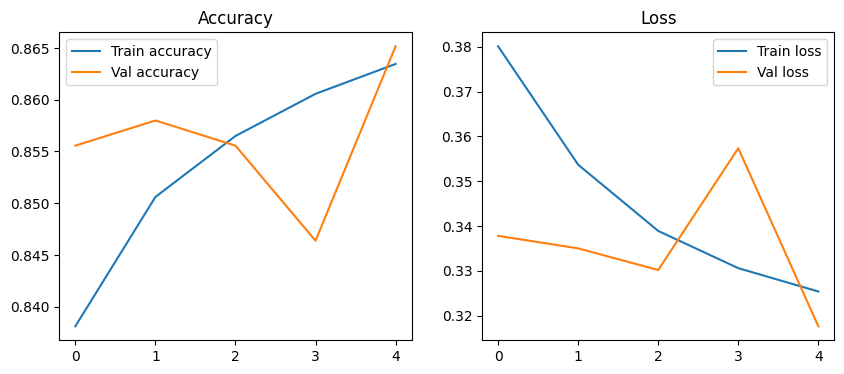

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend()
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.title('Loss')
plt.show()


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 85s 49ms/step


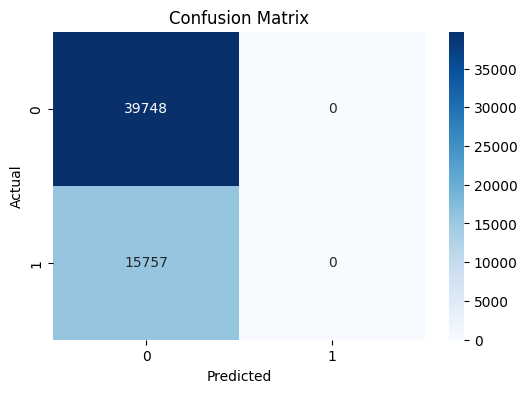

              precision    recall  f1-score   support

           0       0.72      1.00      0.83     39748
           1       0.00      0.00      0.00     15757

    accuracy                           0.72     55505
   macro avg       0.36      0.50      0.42     55505
weighted avg       0.51      0.72      0.60     55505



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predictions generate
y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred))

In [ ]:
model.save("breast_cancer_cnn_model.h5")
print("✅ Model Saved Successfully!")

✅ Model Saved Successfully!


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

loaded_model = load_model("breast_cancer_cnn_model.h5")
print("✅ Model Loaded!")

# Load and preprocess an example image from the test dataset
example_image_path = test_df["path"].iloc[0]  # Get the path of the first image in the test set
img = image.load_img(example_image_path, target_size=(50, 50))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale the image

# Example Prediction
prediction = loaded_model.predict(img_array)
print("Prediction:", prediction)

# Interpret the prediction
if prediction[0][0] > 0.5:
    print("Predicted Class: Malignant (1)")
else:
    print("Predicted Class: Benign (0)")

✅ Model Loaded!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Prediction: [[0.00594873]]
Predicted Class: Benign (0)


In [ ]:
prediction = model.predict(img_array)
benign_prob = (1 - prediction[0][0]) * 100
malignant_prob = prediction[0][0] * 100

print(f"Benign Probability: {benign_prob:.2f}%")
print(f"Malignant Probability: {malignant_prob:.2f}%")

if prediction[0][0] < 0.5:
    print("✅ Predicted Class: Benign (0)")
else:
    print("⚠️ Predicted Class: Malignant (1)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
Benign Probability: 99.41%
Malignant Probability: 0.59%
✅ Predicted Class: Benign (0)
